# Air Quality over Time - Working with dates and times

For this module, we will be exploring the techniques for working with dates and times. 

You will learn about:

* Parsing Dates
* Cleaning up data
* Fixing "Numerical" Strings
* Making functions
* Timezones
* Resampling
* Rolling operations
* Plotting

# Air Quality Data

https://archive.ics.uci.edu/ml/datasets/Air+Quality

0. Date (DD/MM/YYYY)
1. Time (HH.MM.SS)
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. True hourly averaged NOx concentration in ppb (reference analyzer)
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. Temperature in Â°C
13. Relative Humidity (%)
14. AH Absolute Humidity

In [1]:
# Expect an error (for demonstration purposes)
# ValueError: Found non-unique column index

import numpy as np
import pandas as pd
import polars as pl
import zipfile
# with zipfile.ZipFile('data/AirQualityUCI.zip') as zip:
#   df = pd.read_csv(zip.open('AirQualityUCI.csv'), sep=';',
#                   dtype_backend='pyarrow', engine='pyarrow')
  
# df

In [2]:
with zipfile.ZipFile('data/AirQualityUCI.zip') as zip:
  df = pd.read_csv(zip.open('AirQualityUCI.csv'), sep=';',
                  dtype_backend='pyarrow', #engine='pyarrow',
                  )

df.sample(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
6252,26/11/2004,06.00.00,1,974,-200,"4,6",743,203,864,75,1155,885,"9,1","77,3","0,8944",<NA>,<NA>
1788,24/05/2004,06.00.00,"0,5",864,-200,"2,8",642,72,1288,69,1255,441,"16,5","36,2","0,6752",<NA>,<NA>
251,21/03/2004,05.00.00,"1,1",1062,-200,"4,0",711,55,1136,66,1461,700,"14,9","60,6","1,0196",<NA>,<NA>
1634,17/05/2004,20.00.00,3,1094,-200,"12,7",1072,170,888,122,1545,1105,"22,0","24,0","0,6263",<NA>,<NA>
4916,01/10/2004,14.00.00,"3,2",-200,-200,"-200,0",-200,383,-200,123,-200,-200,-200,-200,-200,<NA>,<NA>


In [3]:
with zipfile.ZipFile("data/AirQualityUCI.zip") as zip:
    df_pl = pl.read_csv(
        zip.open("AirQualityUCI.csv"),
        separator=";",
        use_pyarrow=True, # This solves the repeated column "empty" names
    )

In [4]:
df_pl.sample(5)

Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,column_15,column_16
str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,str,str,str,null,null
"""25/02/2005""","""14.00.00""","""2,2""",1021,-200,"""7,6""",882,305,727,137,1097,847,"""11,5""","""42,1""","""0,5706""",null,null
"""24/05/2004""","""07.00.00""","""1,6""",1002,-200,"""7,8""",893,165,1010,111,1394,775,"""17,5""","""30,9""","""0,6111""",null,null
"""19/09/2004""","""06.00.00""","""0,6""",811,-200,"""2,9""",644,76,1144,44,1289,655,"""18,2""","""60,8""","""1,2567""",null,null
"""21/03/2004""","""23.00.00""","""1,9""",1211,-200,"""7,9""",896,112,920,93,1624,1066,"""16,4""","""55,1""","""1,0198""",null,null
"""05/05/2004""","""10.00.00""","""2,9""",1172,-200,"""13,0""",1085,214,737,123,1876,1102,"""16,3""","""68,6""","""1,2657""",null,null


## Clean up Data

In [5]:
(df
 .isna()
 .sum(axis='columns')
)

0        2
1        2
2        2
3        2
4        2
        ..
9466    17
9467    17
9468    17
9469    17
9470    17
Length: 9471, dtype: int64

In [6]:
(df_pl
 .with_columns(
     pl.col(pl.Utf8).replace({"":None}) # Fill `""` as null in string columnsa
 )
 .select(pl.all().is_null())
 .sum_horizontal()
)

sum
u32
2
2
2
2
2
2
2
2
2


In [7]:
df.shape

(9471, 17)

In [8]:
df_pl.shape

(9471, 17)

In [9]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578",<NA>,<NA>
1,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255",<NA>,<NA>
2,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502",<NA>,<NA>
3,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867",<NA>,<NA>
4,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,"3,1",1314,-200,"13,5",1101,472,539,190,1374,1729,"21,9","29,3","0,7568",<NA>,<NA>
9353,04/04/2005,11.00.00,"2,4",1163,-200,"11,4",1027,353,604,179,1264,1269,"24,3","23,7","0,7119",<NA>,<NA>
9354,04/04/2005,12.00.00,"2,4",1142,-200,"12,4",1063,293,603,175,1241,1092,"26,9","18,3","0,6406",<NA>,<NA>
9355,04/04/2005,13.00.00,"2,1",1003,-200,"9,5",961,235,702,156,1041,770,"28,3","13,5","0,5139",<NA>,<NA>


In [10]:
(df_pl
 .with_columns(
     pl.col(pl.Utf8).replace({"":None}) # Fill `""` as null in string columnsa
 )
 .filter(~pl.all_horizontal(pl.all().is_null()))
)

Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,column_15,column_16
str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,str,str,str,null,null
"""10/03/2004""","""18.00.00""","""2,6""",1360,150,"""11,9""",1046,166,1056,113,1692,1268,"""13,6""","""48,9""","""0,7578""",null,null
"""10/03/2004""","""19.00.00""","""2""",1292,112,"""9,4""",955,103,1174,92,1559,972,"""13,3""","""47,7""","""0,7255""",null,null
"""10/03/2004""","""20.00.00""","""2,2""",1402,88,"""9,0""",939,131,1140,114,1555,1074,"""11,9""","""54,0""","""0,7502""",null,null
"""10/03/2004""","""21.00.00""","""2,2""",1376,80,"""9,2""",948,172,1092,122,1584,1203,"""11,0""","""60,0""","""0,7867""",null,null
"""10/03/2004""","""22.00.00""","""1,6""",1272,51,"""6,5""",836,131,1205,116,1490,1110,"""11,2""","""59,6""","""0,7888""",null,null
"""10/03/2004""","""23.00.00""","""1,2""",1197,38,"""4,7""",750,89,1337,96,1393,949,"""11,2""","""59,2""","""0,7848""",null,null
"""11/03/2004""","""00.00.00""","""1,2""",1185,31,"""3,6""",690,62,1462,77,1333,733,"""11,3""","""56,8""","""0,7603""",null,null
"""11/03/2004""","""01.00.00""","""1""",1136,31,"""3,3""",672,62,1453,76,1333,730,"""10,7""","""60,0""","""0,7702""",null,null
"""11/03/2004""","""02.00.00""","""0,9""",1094,24,"""2,3""",609,45,1579,60,1276,620,"""10,7""","""59,7""","""0,7648""",null,null


In [11]:
df_pl = df_pl.with_columns(
    pl.col(pl.Utf8).replace({"": None})  # Fill `""` as null in string columnsa
)

## Date Parsing

In [12]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: (df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True)))
 .loc[:, ['Date', 'Time', 'date']]
)

,Date,Time,date
0,10/03/2004,18.00.00,10/03/2004 18:00:00
1,10/03/2004,19.00.00,10/03/2004 19:00:00
2,10/03/2004,20.00.00,10/03/2004 20:00:00
3,10/03/2004,21.00.00,10/03/2004 21:00:00
4,10/03/2004,22.00.00,10/03/2004 22:00:00
...,...,...,...
9352,04/04/2005,10.00.00,04/04/2005 10:00:00
9353,04/04/2005,11.00.00,04/04/2005 11:00:00
9354,04/04/2005,12.00.00,04/04/2005 12:00:00
9355,04/04/2005,13.00.00,04/04/2005 13:00:00


In [13]:
# Expect an error (for demonstration purposes)
# ValueError: time data "13/03/2004 00:00:00" doesn't match format "%m/%d/%Y %H:%M:%S":

# (df
#  .loc[df.isna().sum(axis='columns') < 17]
#  .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
#                     df_.Time.replace(r'\.', ':', regex=True)))
# )

In [14]:
(df
.Date
.value_counts())

Date
11/03/2004    24
12/03/2004    24
13/03/2004    24
14/03/2004    24
15/03/2004    24
              ..
01/04/2005    24
02/04/2005    24
03/04/2005    24
04/04/2005    15
10/03/2004     6
Name: count, Length: 391, dtype: int64[pyarrow]

In [15]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                                        dayfirst=True))
)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,date
0,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578",<NA>,<NA>,2004-03-10 18:00:00
1,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255",<NA>,<NA>,2004-03-10 19:00:00
2,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502",<NA>,<NA>,2004-03-10 20:00:00
3,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867",<NA>,<NA>,2004-03-10 21:00:00
4,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888",<NA>,<NA>,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,"3,1",1314,-200,"13,5",1101,472,539,190,1374,1729,"21,9","29,3","0,7568",<NA>,<NA>,2005-04-04 10:00:00
9353,04/04/2005,11.00.00,"2,4",1163,-200,"11,4",1027,353,604,179,1264,1269,"24,3","23,7","0,7119",<NA>,<NA>,2005-04-04 11:00:00
9354,04/04/2005,12.00.00,"2,4",1142,-200,"12,4",1063,293,603,175,1241,1092,"26,9","18,3","0,6406",<NA>,<NA>,2005-04-04 12:00:00
9355,04/04/2005,13.00.00,"2,1",1003,-200,"9,5",961,235,702,156,1041,770,"28,3","13,5","0,5139",<NA>,<NA>,2005-04-04 13:00:00


In [16]:
# Alternate
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                    format='%d/%m/%Y %H:%M:%S'))
)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,date
0,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578",<NA>,<NA>,2004-03-10 18:00:00
1,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255",<NA>,<NA>,2004-03-10 19:00:00
2,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502",<NA>,<NA>,2004-03-10 20:00:00
3,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867",<NA>,<NA>,2004-03-10 21:00:00
4,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888",<NA>,<NA>,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,"3,1",1314,-200,"13,5",1101,472,539,190,1374,1729,"21,9","29,3","0,7568",<NA>,<NA>,2005-04-04 10:00:00
9353,04/04/2005,11.00.00,"2,4",1163,-200,"11,4",1027,353,604,179,1264,1269,"24,3","23,7","0,7119",<NA>,<NA>,2005-04-04 11:00:00
9354,04/04/2005,12.00.00,"2,4",1142,-200,"12,4",1063,293,603,175,1241,1092,"26,9","18,3","0,6406",<NA>,<NA>,2005-04-04 12:00:00
9355,04/04/2005,13.00.00,"2,1",1003,-200,"9,5",961,235,702,156,1041,770,"28,3","13,5","0,5139",<NA>,<NA>,2005-04-04 13:00:00


In [17]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                    format='%d/%m/%Y %H:%M:%S'))
 .dtypes
)

Date             string[pyarrow]
Time             string[pyarrow]
CO(GT)           string[pyarrow]
PT08.S1(CO)       int64[pyarrow]
NMHC(GT)          int64[pyarrow]
C6H6(GT)         string[pyarrow]
PT08.S2(NMHC)     int64[pyarrow]
NOx(GT)           int64[pyarrow]
PT08.S3(NOx)      int64[pyarrow]
NO2(GT)           int64[pyarrow]
PT08.S4(NO2)      int64[pyarrow]
PT08.S5(O3)       int64[pyarrow]
T                string[pyarrow]
RH               string[pyarrow]
AH               string[pyarrow]
Unnamed: 15        null[pyarrow]
Unnamed: 16        null[pyarrow]
date              datetime64[ns]
dtype: object

In [18]:
(df_pl
.filter(~pl.all_horizontal(pl.all().is_null()))
 .with_columns(
     date = pl.col("Date") + " " + pl.col("Time").str.replace_all(r"\.", ":")
 )
 .with_columns(
     date = pl.col("date").str.to_datetime()
 )
 .dtypes
)

[String,
 String,
 String,
 Int64,
 Int64,
 String,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 String,
 String,
 String,
 Null,
 Null,
 Datetime(time_unit='us', time_zone=None)]

## Rename Columns

In [19]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                    format='%d/%m/%Y %H:%M:%S'))
 .rename(columns={'CO(GT)': 'carbon_monoxide',
                  'PT08.S1(CO)': 'tin_oxide',
                  'NMHC(GT)': 'non_metallic_hydro_carb',
                  'C6H6(GT)': 'benzene',
                  'PT08.S2(NMHC)': 'titania',
                  'NOx(GT)': 'nox',
                  'PT08.S3(NOx)': 'tungsten_oxide_nox',
                  'NO2(GT)': 'no2',
                  'PT08.S4(NO2)':  'tungsten_oxide_no2',
                  'PT08.S5(O3)': 'indium_oxide',
                  'T': 'temp',
                  'RH': 'rel_humid',
                  'AH': 'abs_humid'})
 
 .columns
)

Index(['Date', 'Time', 'carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'Unnamed: 15', 'Unnamed: 16', 'date'],
      dtype='object')

In [20]:
df['Unnamed: 15'].value_counts()

Series([], Name: count, dtype: int64[pyarrow])

In [21]:
df['Unnamed: 16'].value_counts()

Series([], Name: count, dtype: int64[pyarrow])

In [22]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                    format='%d/%m/%Y %H:%M:%S'))
 .rename(columns={'CO(GT)': 'carbon_monoxide',
                  'PT08.S1(CO)': 'tin_oxide',
                  'NMHC(GT)': 'non_metallic_hydro_carb',
                  'C6H6(GT)': 'benzene',
                  'PT08.S2(NMHC)': 'titania',
                  'NOx(GT)': 'nox',
                  'PT08.S3(NOx)': 'tungsten_oxide_nox',
                  'NO2(GT)': 'no2',
                  'PT08.S4(NO2)':  'tungsten_oxide_no2',
                  'PT08.S5(O3)': 'indium_oxide',
                  'T': 'temp',
                  'RH': 'rel_humid',
                  'AH': 'abs_humid'})
 .loc[:, ['carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'date']]
)

,carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
0,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888",2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,"3,1",1314,-200,"13,5",1101,472,539,190,1374,1729,"21,9","29,3","0,7568",2005-04-04 10:00:00
9353,"2,4",1163,-200,"11,4",1027,353,604,179,1264,1269,"24,3","23,7","0,7119",2005-04-04 11:00:00
9354,"2,4",1142,-200,"12,4",1063,293,603,175,1241,1092,"26,9","18,3","0,6406",2005-04-04 12:00:00
9355,"2,1",1003,-200,"9,5",961,235,702,156,1041,770,"28,3","13,5","0,5139",2005-04-04 13:00:00


In [23]:
(df_pl
 .filter(~pl.all_horizontal(pl.all().is_null()))
 .with_columns(
     date=pl.col("Date") + " " + pl.col("Time").str.replace_all(r"\.", ":")
     )
 .with_columns(date=pl.col("date").str.to_datetime())
 .rename(
     {
         "CO(GT)": "carbon_monoxide",
         "PT08.S1(CO)": "tin_oxide",
         "NMHC(GT)": "non_metallic_hydro_carb",
         "C6H6(GT)": "benzene",
         "PT08.S2(NMHC)": "titania",
         "NOx(GT)": "nox",
         "PT08.S3(NOx)": "tungsten_oxide_nox",
         "NO2(GT)": "no2",
         "PT08.S4(NO2)": "tungsten_oxide_no2",
         "PT08.S5(O3)": "indium_oxide",
         "T": "temp",
         "RH": "rel_humid",
         "AH": "abs_humid",
        }
    )
 .select(['carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'date'])
)

carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
str,i64,i64,str,i64,i64,i64,i64,i64,i64,str,str,str,datetime[μs]
"""2,6""",1360,150,"""11,9""",1046,166,1056,113,1692,1268,"""13,6""","""48,9""","""0,7578""",2004-03-10 18:00:00
"""2""",1292,112,"""9,4""",955,103,1174,92,1559,972,"""13,3""","""47,7""","""0,7255""",2004-03-10 19:00:00
"""2,2""",1402,88,"""9,0""",939,131,1140,114,1555,1074,"""11,9""","""54,0""","""0,7502""",2004-03-10 20:00:00
"""2,2""",1376,80,"""9,2""",948,172,1092,122,1584,1203,"""11,0""","""60,0""","""0,7867""",2004-03-10 21:00:00
"""1,6""",1272,51,"""6,5""",836,131,1205,116,1490,1110,"""11,2""","""59,6""","""0,7888""",2004-03-10 22:00:00
"""1,2""",1197,38,"""4,7""",750,89,1337,96,1393,949,"""11,2""","""59,2""","""0,7848""",2004-03-10 23:00:00
"""1,2""",1185,31,"""3,6""",690,62,1462,77,1333,733,"""11,3""","""56,8""","""0,7603""",2004-03-11 00:00:00
"""1""",1136,31,"""3,3""",672,62,1453,76,1333,730,"""10,7""","""60,0""","""0,7702""",2004-03-11 01:00:00
"""0,9""",1094,24,"""2,3""",609,45,1579,60,1276,620,"""10,7""","""59,7""","""0,7648""",2004-03-11 02:00:00


## Fixing Numerical "Strings"

In [24]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                    format='%d/%m/%Y %H:%M:%S'))
 .rename(columns={'CO(GT)': 'carbon_monoxide',
                  'PT08.S1(CO)': 'tin_oxide',
                  'NMHC(GT)': 'non_metallic_hydro_carb',
                  'C6H6(GT)': 'benzene',
                  'PT08.S2(NMHC)': 'titania',
                  'NOx(GT)': 'nox',
                  'PT08.S3(NOx)': 'tungsten_oxide_nox',
                  'NO2(GT)': 'no2',
                  'PT08.S4(NO2)':  'tungsten_oxide_no2',
                  'PT08.S5(O3)': 'indium_oxide',
                  'T': 'temp',
                  'RH': 'rel_humid',
                  'AH': 'abs_humid'})
 .loc[:, ['carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'date']]
 .select_dtypes('string')
)

,carbon_monoxide,benzene,temp,rel_humid,abs_humid
0,"2,6","11,9","13,6","48,9","0,7578"
1,2,"9,4","13,3","47,7","0,7255"
2,"2,2","9,0","11,9","54,0","0,7502"
3,"2,2","9,2","11,0","60,0","0,7867"
4,"1,6","6,5","11,2","59,6","0,7888"
...,...,...,...,...,...
9352,"3,1","13,5","21,9","29,3","0,7568"
9353,"2,4","11,4","24,3","23,7","0,7119"
9354,"2,4","12,4","26,9","18,3","0,6406"
9355,"2,1","9,5","28,3","13,5","0,5139"


In [25]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                    format='%d/%m/%Y %H:%M:%S'))
 .rename(columns={'CO(GT)': 'carbon_monoxide',
                  'PT08.S1(CO)': 'tin_oxide',
                  'NMHC(GT)': 'non_metallic_hydro_carb',
                  'C6H6(GT)': 'benzene',
                  'PT08.S2(NMHC)': 'titania',
                  'NOx(GT)': 'nox',
                  'PT08.S3(NOx)': 'tungsten_oxide_nox',
                  'NO2(GT)': 'no2',
                  'PT08.S4(NO2)':  'tungsten_oxide_no2',
                  'PT08.S5(O3)': 'indium_oxide',
                  'T': 'temp',
                  'RH': 'rel_humid',
                  'AH': 'abs_humid'})
 .loc[:, ['carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'date']]
 .pipe(lambda df_: df_.assign(**{col: df_[col].str.replace(',','.').astype('float[pyarrow]')
                                for col in
      ['carbon_monoxide', 'benzene', 'temp', 'rel_humid', 'abs_humid']}))
)

,carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.600000,48.900002,0.7578,2004-03-10 18:00:00
1,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.300000,47.700001,0.7255,2004-03-10 19:00:00
2,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.900000,54.000000,0.7502,2004-03-10 20:00:00
3,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.000000,60.000000,0.7867,2004-03-10 21:00:00
4,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.200000,59.599998,0.7888,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.900000,29.299999,0.7568,2005-04-04 10:00:00
9353,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.299999,23.700001,0.7119,2005-04-04 11:00:00
9354,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.900000,18.299999,0.6406,2005-04-04 12:00:00
9355,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.299999,13.500000,0.5139,2005-04-04 13:00:00


In [26]:
(df_pl
 .filter(~pl.all_horizontal(pl.all().is_null()))
 .with_columns(
     date=pl.col("Date") + " " + pl.col("Time").str.replace_all(r"\.", ":")
 )
 .with_columns(
     date=pl.col("date").str.to_datetime()
 )
 .rename(
     {
         "CO(GT)": "carbon_monoxide",
         "PT08.S1(CO)": "tin_oxide",
         "NMHC(GT)": "non_metallic_hydro_carb",
         "C6H6(GT)": "benzene",
         "PT08.S2(NMHC)": "titania",
         "NOx(GT)": "nox",
         "PT08.S3(NOx)": "tungsten_oxide_nox",
         "NO2(GT)": "no2",
         "PT08.S4(NO2)": "tungsten_oxide_no2",
         "PT08.S5(O3)": "indium_oxide",
         "T": "temp",
         "RH": "rel_humid",
         "AH": "abs_humid",
        }
 )
 .select(['carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'date'])
 .with_columns(
     **{col: pl.col(col).str.replace(r"\,", ".").cast(pl.Float64)
        for col in ['carbon_monoxide', 'benzene', 'temp', 'rel_humid', 'abs_humid']}
 )
)

carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,datetime[μs]
2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00
1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,2004-03-10 23:00:00
1.2,1185,31,3.6,690,62,1462,77,1333,733,11.3,56.8,0.7603,2004-03-11 00:00:00
1.0,1136,31,3.3,672,62,1453,76,1333,730,10.7,60.0,0.7702,2004-03-11 01:00:00
0.9,1094,24,2.3,609,45,1579,60,1276,620,10.7,59.7,0.7648,2004-03-11 02:00:00


In [27]:
(df
 .loc[df.isna().sum(axis='columns') < 17]
 .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                    df_.Time.replace(r'\.', ':', regex=True),
                    format='%d/%m/%Y %H:%M:%S'))
 .rename(columns={'CO(GT)': 'carbon_monoxide',
                  'PT08.S1(CO)': 'tin_oxide',
                  'NMHC(GT)': 'non_metallic_hydro_carb',
                  'C6H6(GT)': 'benzene',
                  'PT08.S2(NMHC)': 'titania',
                  'NOx(GT)': 'nox',
                  'PT08.S3(NOx)': 'tungsten_oxide_nox',
                  'NO2(GT)': 'no2',
                  'PT08.S4(NO2)':  'tungsten_oxide_no2',
                  'PT08.S5(O3)': 'indium_oxide',
                  'T': 'temp',
                  'RH': 'rel_humid',
                  'AH': 'abs_humid'})
 .loc[:, ['carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'date']]
 .pipe(lambda df_: df_.assign(**{col: df_[col].str.replace(',','.').astype('float[pyarrow]')
                                for col in
      ['carbon_monoxide', 'benzene', 'temp', 'rel_humid', 'abs_humid']}))
 .dtypes
)

carbon_monoxide            float[pyarrow]
tin_oxide                  int64[pyarrow]
non_metallic_hydro_carb    int64[pyarrow]
benzene                    float[pyarrow]
titania                    int64[pyarrow]
nox                        int64[pyarrow]
tungsten_oxide_nox         int64[pyarrow]
no2                        int64[pyarrow]
tungsten_oxide_no2         int64[pyarrow]
indium_oxide               int64[pyarrow]
temp                       float[pyarrow]
rel_humid                  float[pyarrow]
abs_humid                  float[pyarrow]
date                       datetime64[ns]
dtype: object

In [28]:
(df_pl
 .filter(~pl.all_horizontal(pl.all().is_null()))
 .with_columns(
     date=pl.col("Date") + " " + pl.col("Time").str.replace_all(r"\.", ":")
 )
 .with_columns(
     date=pl.col("date").str.to_datetime()
 )
 .rename(
     {
         "CO(GT)": "carbon_monoxide",
         "PT08.S1(CO)": "tin_oxide",
         "NMHC(GT)": "non_metallic_hydro_carb",
         "C6H6(GT)": "benzene",
         "PT08.S2(NMHC)": "titania",
         "NOx(GT)": "nox",
         "PT08.S3(NOx)": "tungsten_oxide_nox",
         "NO2(GT)": "no2",
         "PT08.S4(NO2)": "tungsten_oxide_no2",
         "PT08.S5(O3)": "indium_oxide",
         "T": "temp",
         "RH": "rel_humid",
         "AH": "abs_humid",
        }
 )
 .select(['carbon_monoxide', 'tin_oxide',
       'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
       'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
       'temp', 'rel_humid', 'abs_humid', 'date'])
 .with_columns(
     **{col: pl.col(col).str.replace(r"\,", ".").cast(pl.Float64)
        for col in ['carbon_monoxide', 'benzene', 'temp', 'rel_humid', 'abs_humid']}
 )
 .dtypes
)

[Float64,
 Int64,
 Int64,
 Float64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Float64,
 Float64,
 Float64,
 Datetime(time_unit='us', time_zone=None)]

## Make a Function

In [29]:
import numpy as np
import pandas as pd
import zipfile

In [30]:
with zipfile.ZipFile('data/AirQualityUCI.zip') as zip:
  df = pd.read_csv(zip.open('AirQualityUCI.csv'), sep=';',
                  dtype_backend='pyarrow')
  
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578",<NA>,<NA>
1,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255",<NA>,<NA>
2,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502",<NA>,<NA>
3,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867",<NA>,<NA>
4,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9467,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9468,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9469,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [31]:
def tweak_air_qual(df:pd.DataFrame) -> pl.DataFrame:
  return (df
     .loc[df.isna().sum(axis='columns') < 17]
     .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                        df_.Time.replace(r'\.', ':', regex=True),
                        format='%d/%m/%Y %H:%M:%S'))
     .rename(columns={'CO(GT)': 'carbon_monoxide',
                      'PT08.S1(CO)': 'tin_oxide',
                      'NMHC(GT)': 'non_metallic_hydro_carb',
                      'C6H6(GT)': 'benzene',
                      'PT08.S2(NMHC)': 'titania',
                      'NOx(GT)': 'nox',
                      'PT08.S3(NOx)': 'tungsten_oxide_nox',
                      'NO2(GT)': 'no2',
                      'PT08.S4(NO2)':  'tungsten_oxide_no2',
                      'PT08.S5(O3)': 'indium_oxide',
                      'T': 'temp',
                      'RH': 'rel_humid',
                      'AH': 'abs_humid'})
     .loc[:, ['carbon_monoxide', 'tin_oxide',
           'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
           'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
           'temp', 'rel_humid', 'abs_humid', 'date']]
     .pipe(lambda df_: df_.assign(**{col: df_[col].str.replace(',','.').astype('float[pyarrow]')
                                    for col in
          ['carbon_monoxide', 'benzene', 'temp', 'rel_humid', 'abs_humid']}))
    )

air_df = tweak_air_qual(df)  

In [32]:
air_df

,carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.600000,48.900002,0.7578,2004-03-10 18:00:00
1,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.300000,47.700001,0.7255,2004-03-10 19:00:00
2,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.900000,54.000000,0.7502,2004-03-10 20:00:00
3,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.000000,60.000000,0.7867,2004-03-10 21:00:00
4,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.200000,59.599998,0.7888,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.900000,29.299999,0.7568,2005-04-04 10:00:00
9353,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.299999,23.700001,0.7119,2005-04-04 11:00:00
9354,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.900000,18.299999,0.6406,2005-04-04 12:00:00
9355,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.299999,13.500000,0.5139,2005-04-04 13:00:00


In [33]:
def tweak_air_qual_pl(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.filter(~pl.all_horizontal(pl.all().is_null()))
        .with_columns(
            date=pl.col("Date") + " " + pl.col("Time").str.replace_all(r"\.", ":")
        )
        .with_columns(date=pl.col("date").str.to_datetime())
        .rename(
            {
                "CO(GT)": "carbon_monoxide",
                "PT08.S1(CO)": "tin_oxide",
                "NMHC(GT)": "non_metallic_hydro_carb",
                "C6H6(GT)": "benzene",
                "PT08.S2(NMHC)": "titania",
                "NOx(GT)": "nox",
                "PT08.S3(NOx)": "tungsten_oxide_nox",
                "NO2(GT)": "no2",
                "PT08.S4(NO2)": "tungsten_oxide_no2",
                "PT08.S5(O3)": "indium_oxide",
                "T": "temp",
                "RH": "rel_humid",
                "AH": "abs_humid",
            }
        )
        .select(
            [
                "carbon_monoxide",
                "tin_oxide",
                "non_metallic_hydro_carb",
                "benzene",
                "titania",
                "nox",
                "tungsten_oxide_nox",
                "no2",
                "tungsten_oxide_no2",
                "indium_oxide",
                "temp",
                "rel_humid",
                "abs_humid",
                "date",
            ]
        )
        .with_columns(
            **{
                col: pl.col(col).str.replace(r"\,", ".").cast(pl.Float64)
                for col in [
                    "carbon_monoxide",
                    "benzene",
                    "temp",
                    "rel_humid",
                    "abs_humid",
                ]
            }
        )
    )

In [34]:
air_df_pl = tweak_air_qual_pl(df_pl)

In [35]:
air_df_pl

carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,datetime[μs]
2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00
1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,2004-03-10 23:00:00
1.2,1185,31,3.6,690,62,1462,77,1333,733,11.3,56.8,0.7603,2004-03-11 00:00:00
1.0,1136,31,3.3,672,62,1453,76,1333,730,10.7,60.0,0.7702,2004-03-11 01:00:00
0.9,1094,24,2.3,609,45,1579,60,1276,620,10.7,59.7,0.7648,2004-03-11 02:00:00


## Convert to UTC

In [36]:
air_df.date

0      2004-03-10 18:00:00
1      2004-03-10 19:00:00
2      2004-03-10 20:00:00
3      2004-03-10 21:00:00
4      2004-03-10 22:00:00
               ...        
9352   2005-04-04 10:00:00
9353   2005-04-04 11:00:00
9354   2005-04-04 12:00:00
9355   2005-04-04 13:00:00
9356   2005-04-04 14:00:00
Name: date, Length: 9357, dtype: datetime64[ns]

In [37]:
air_df_pl["date"]

date
datetime[μs]
2004-03-10 18:00:00
2004-03-10 19:00:00
2004-03-10 20:00:00
2004-03-10 21:00:00
2004-03-10 22:00:00
2004-03-10 23:00:00
2004-03-11 00:00:00
2004-03-11 01:00:00
2004-03-11 02:00:00


In [38]:
air_df.date.dt.tz_localize(tz='UTC')

0      2004-03-10 18:00:00+00:00
1      2004-03-10 19:00:00+00:00
2      2004-03-10 20:00:00+00:00
3      2004-03-10 21:00:00+00:00
4      2004-03-10 22:00:00+00:00
                  ...           
9352   2005-04-04 10:00:00+00:00
9353   2005-04-04 11:00:00+00:00
9354   2005-04-04 12:00:00+00:00
9355   2005-04-04 13:00:00+00:00
9356   2005-04-04 14:00:00+00:00
Name: date, Length: 9357, dtype: datetime64[ns, UTC]

In [39]:
air_df_pl["date"].dt.replace_time_zone(time_zone="UTC")

date
"datetime[μs, UTC]"
2004-03-10 18:00:00 UTC
2004-03-10 19:00:00 UTC
2004-03-10 20:00:00 UTC
2004-03-10 21:00:00 UTC
2004-03-10 22:00:00 UTC
2004-03-10 23:00:00 UTC
2004-03-11 00:00:00 UTC
2004-03-11 01:00:00 UTC
2004-03-11 02:00:00 UTC


In [40]:
air_df.date.convert_dtypes('timestamp[ns][pyarrow]').dt.tz_localize('UTC')

0      2004-03-10 18:00:00+00:00
1      2004-03-10 19:00:00+00:00
2      2004-03-10 20:00:00+00:00
3      2004-03-10 21:00:00+00:00
4      2004-03-10 22:00:00+00:00
                  ...           
9352   2005-04-04 10:00:00+00:00
9353   2005-04-04 11:00:00+00:00
9354   2005-04-04 12:00:00+00:00
9355   2005-04-04 13:00:00+00:00
9356   2005-04-04 14:00:00+00:00
Name: date, Length: 9357, dtype: datetime64[ns, UTC]

## Convert to Italian Time

In [41]:
import pytz
from pprint import pprint

In [42]:
pprint(pytz.all_timezones)

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [43]:
pprint([tz for tz in pytz.all_timezones if 'Europe' in tz])

['Europe/Amsterdam',
 'Europe/Andorra',
 'Europe/Astrakhan',
 'Europe/Athens',
 'Europe/Belfast',
 'Europe/Belgrade',
 'Europe/Berlin',
 'Europe/Bratislava',
 'Europe/Brussels',
 'Europe/Bucharest',
 'Europe/Budapest',
 'Europe/Busingen',
 'Europe/Chisinau',
 'Europe/Copenhagen',
 'Europe/Dublin',
 'Europe/Gibraltar',
 'Europe/Guernsey',
 'Europe/Helsinki',
 'Europe/Isle_of_Man',
 'Europe/Istanbul',
 'Europe/Jersey',
 'Europe/Kaliningrad',
 'Europe/Kiev',
 'Europe/Kirov',
 'Europe/Kyiv',
 'Europe/Lisbon',
 'Europe/Ljubljana',
 'Europe/London',
 'Europe/Luxembourg',
 'Europe/Madrid',
 'Europe/Malta',
 'Europe/Mariehamn',
 'Europe/Minsk',
 'Europe/Monaco',
 'Europe/Moscow',
 'Europe/Nicosia',
 'Europe/Oslo',
 'Europe/Paris',
 'Europe/Podgorica',
 'Europe/Prague',
 'Europe/Riga',
 'Europe/Rome',
 'Europe/Samara',
 'Europe/San_Marino',
 'Europe/Sarajevo',
 'Europe/Saratov',
 'Europe/Simferopol',
 'Europe/Skopje',
 'Europe/Sofia',
 'Europe/Stockholm',
 'Europe/Tallinn',
 'Europe/Tirane',
 '

In [44]:
# Expect an error (for demonstration purposes)
# NonExistentTimeError: 2004-03-28 02:00:00

# air_df.date.dt.tz_localize('Europe/Rome')

In [45]:
air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome')

0      2004-03-10 19:00:00+01:00
1      2004-03-10 20:00:00+01:00
2      2004-03-10 21:00:00+01:00
3      2004-03-10 22:00:00+01:00
4      2004-03-10 23:00:00+01:00
                  ...           
9352   2005-04-04 12:00:00+02:00
9353   2005-04-04 13:00:00+02:00
9354   2005-04-04 14:00:00+02:00
9355   2005-04-04 15:00:00+02:00
9356   2005-04-04 16:00:00+02:00
Name: date, Length: 9357, dtype: datetime64[ns, Europe/Rome]

In [46]:
(air_df
 .date
 .convert_dtypes('timestamp[ns][pyarrow]')
 .dt.tz_localize('UTC')
 .dt.tz_convert('Europe/Rome')
)

0      2004-03-10 19:00:00+01:00
1      2004-03-10 20:00:00+01:00
2      2004-03-10 21:00:00+01:00
3      2004-03-10 22:00:00+01:00
4      2004-03-10 23:00:00+01:00
                  ...           
9352   2005-04-04 12:00:00+02:00
9353   2005-04-04 13:00:00+02:00
9354   2005-04-04 14:00:00+02:00
9355   2005-04-04 15:00:00+02:00
9356   2005-04-04 16:00:00+02:00
Name: date, Length: 9357, dtype: datetime64[ns, Europe/Rome]

In [47]:
# Note that CET works but isn't a timezone
air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('CET')

0      2004-03-10 19:00:00+01:00
1      2004-03-10 20:00:00+01:00
2      2004-03-10 21:00:00+01:00
3      2004-03-10 22:00:00+01:00
4      2004-03-10 23:00:00+01:00
                  ...           
9352   2005-04-04 12:00:00+02:00
9353   2005-04-04 13:00:00+02:00
9354   2005-04-04 14:00:00+02:00
9355   2005-04-04 15:00:00+02:00
9356   2005-04-04 16:00:00+02:00
Name: date, Length: 9357, dtype: datetime64[ns, CET]

In [48]:
(air_df_pl
 ["date"]
 .dt.replace_time_zone("UTC")
 .dt.convert_time_zone("Europe/Rome")
)

date
"datetime[μs, Europe/Rome]"
2004-03-10 19:00:00 CET
2004-03-10 20:00:00 CET
2004-03-10 21:00:00 CET
2004-03-10 22:00:00 CET
2004-03-10 23:00:00 CET
2004-03-11 00:00:00 CET
2004-03-11 01:00:00 CET
2004-03-11 02:00:00 CET
2004-03-11 03:00:00 CET


## Plotting

In [49]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc[:, ['carbon_monoxide', 'benzene']]
)

,carbon_monoxide,benzene
date,,
2004-03-10 19:00:00+01:00,2.6,11.9
2004-03-10 20:00:00+01:00,2.0,9.4
2004-03-10 21:00:00+01:00,2.2,9.0
2004-03-10 22:00:00+01:00,2.2,9.2
2004-03-10 23:00:00+01:00,1.6,6.5
...,...,...
2005-04-04 12:00:00+02:00,3.1,13.5
2005-04-04 13:00:00+02:00,2.4,11.4
2005-04-04 14:00:00+02:00,2.4,12.4


In [50]:
(air_df
 .assign(date=air_df.date.convert_dtypes('timestamp[ns][pyarrow]').dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc[:, ['carbon_monoxide', 'benzene']]
)

,carbon_monoxide,benzene
date,,
2004-03-10 19:00:00+01:00,2.6,11.9
2004-03-10 20:00:00+01:00,2.0,9.4
2004-03-10 21:00:00+01:00,2.2,9.0
2004-03-10 22:00:00+01:00,2.2,9.2
2004-03-10 23:00:00+01:00,1.6,6.5
...,...,...
2005-04-04 12:00:00+02:00,3.1,13.5
2005-04-04 13:00:00+02:00,2.4,11.4
2005-04-04 14:00:00+02:00,2.4,12.4


<Axes: xlabel='date'>

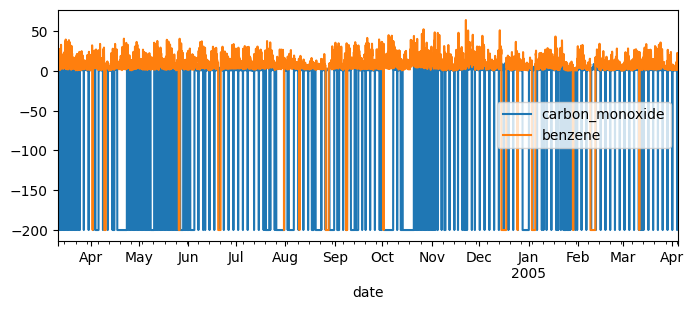

In [51]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc[:, ['carbon_monoxide', 'benzene']]
 .plot(figsize=(8,3))
)

In [52]:
(air_df_pl
 .with_columns(
     date = pl.col("date").dt.replace_time_zone("UTC")
                          .dt.convert_time_zone("Europe/Rome")
 )
 .select(["date", "carbon_monoxide", "benzene"])
 .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

<Axes: xlabel='date'>

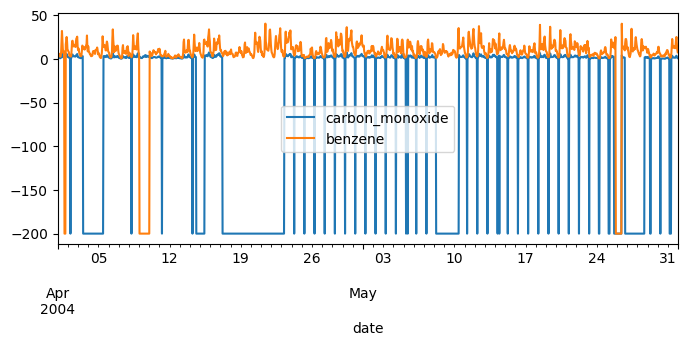

In [53]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04':'2004/05', ['carbon_monoxide', 'benzene']]
 .plot(figsize=(8,3))
)

In [54]:
from datetime import datetime

In [55]:
datetime(2004, 4, 1, tzinfo=pytz.timezone("Europe/Rome"))

datetime.datetime(2004, 4, 1, 0, 0, tzinfo=<DstTzInfo 'Europe/Rome' LMT+0:50:00 STD>)

In [56]:
(air_df_pl
 .with_columns(
     date = pl.col("date").dt.replace_time_zone("UTC")
                          .dt.convert_time_zone("Europe/Rome")
 )
 .select(["date", "carbon_monoxide", "benzene"])
 .filter(pl.col("date").is_between(
     datetime(2004, 4, 1, tzinfo=pytz.timezone("Europe/Rome")),
     datetime(2004, 5, 31, tzinfo=pytz.timezone("Europe/Rome"))
 ))
 .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

<Axes: xlabel='date'>

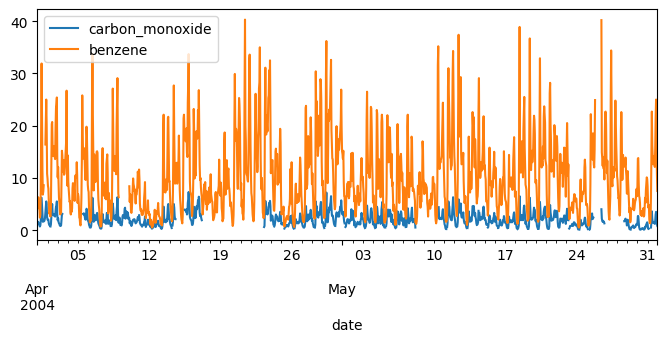

In [57]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04':'2004/05', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .plot(figsize=(8,3)) 
)

In [58]:
(air_df_pl
 .with_columns(
     date = pl.col("date").dt.replace_time_zone("UTC")
                          .dt.convert_time_zone("Europe/Rome")
 )
 .select(["date", "carbon_monoxide", "benzene"])
 .filter(pl.col("date").is_between(
     datetime(2004, 4, 1, tzinfo=pytz.timezone("Europe/Rome")),
     datetime(2004, 5, 31, tzinfo=pytz.timezone("Europe/Rome"))
 ))
 .with_columns(
     pl.col(pl.Float64).replace({-200:0})
 )
 .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

<Axes: xlabel='date'>

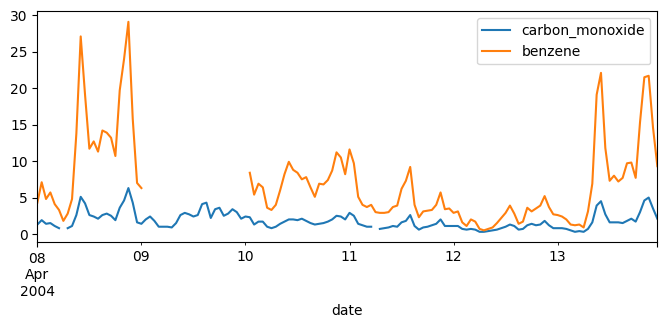

In [59]:
# zoom in a little more
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .plot(figsize=(8,3)) 
)

In [60]:
(air_df_pl
 .with_columns(
     date = pl.col("date").dt.replace_time_zone("UTC")
                          .dt.convert_time_zone("Europe/Rome")
 )
 .select(["date", "carbon_monoxide", "benzene"])
 .filter(pl.col("date").is_between(
     datetime(2004, 4, 8, tzinfo=pytz.timezone("Europe/Rome")),
     datetime(2004, 4, 14, tzinfo=pytz.timezone("Europe/Rome"))
 ))
 .with_columns(
     pl.col(pl.Float64).replace({-200:0})
 )
 .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

## Missing Values

<Axes: xlabel='date'>

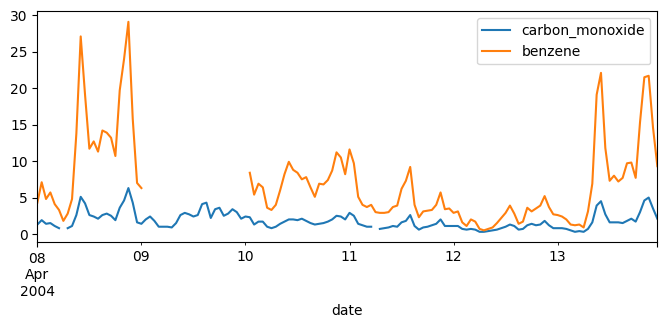

In [61]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .plot(figsize=(8,3))
)

In [62]:
# Expect an error (for demonstration purposes)
# TypeError: ExtensionArray.interpolate() missing 1 required keyword-only argument: 'fill_value'

# (air_df
#  .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
#  .set_index('date')
#  .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
#  .replace(-200, np.nan)
#  .interpolate()
#  .plot(figsize=(8,3))
# )

<Axes: xlabel='date'>

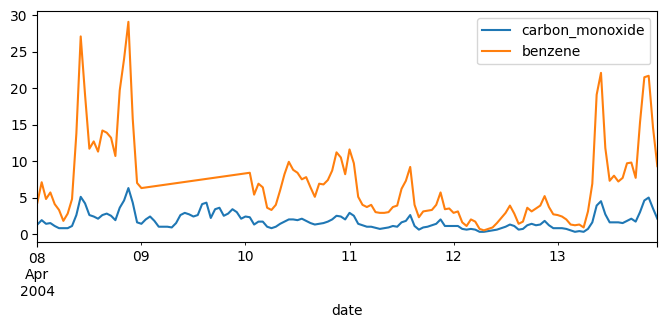

In [63]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 .plot(figsize=(8,3))
)

In [64]:
(air_df_pl
 .with_columns(
     date = pl.col("date").dt.replace_time_zone("UTC")
                          .dt.convert_time_zone("Europe/Rome")
 )
 .select(["date", "carbon_monoxide", "benzene"])
 .filter(pl.col("date").is_between(
     datetime(2004, 4, 8, tzinfo=pytz.timezone("Europe/Rome")),
     datetime(2004, 4, 14, tzinfo=pytz.timezone("Europe/Rome"))
 ))
 .with_columns(
     pl.col(pl.Float64).replace({-200:None})
 )
 .interpolate()
 .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

<Axes: xlabel='date'>

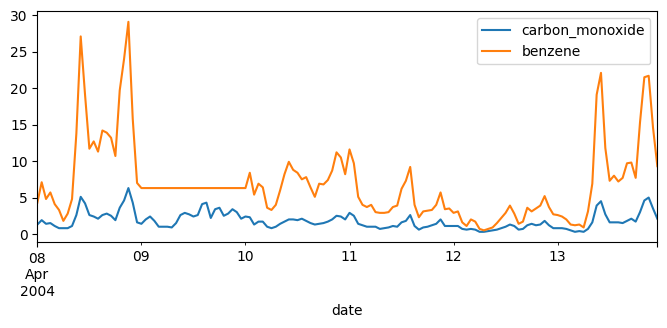

In [65]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .ffill()
 .plot(figsize=(8,3))
)

In [66]:
(air_df_pl
 .with_columns(
     date = pl.col("date").dt.replace_time_zone("UTC")
                          .dt.convert_time_zone("Europe/Rome")
 )
 .select(["date", "carbon_monoxide", "benzene"])
 .filter(pl.col("date").is_between(
     datetime(2004, 4, 8, tzinfo=pytz.timezone("Europe/Rome")),
     datetime(2004, 4, 14, tzinfo=pytz.timezone("Europe/Rome"))
 ))
 .with_columns(
     pl.col(pl.Float64).replace({-200:None}).forward_fill() #forward fill works with pl.Expr
 )
 .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

<Axes: xlabel='date'>

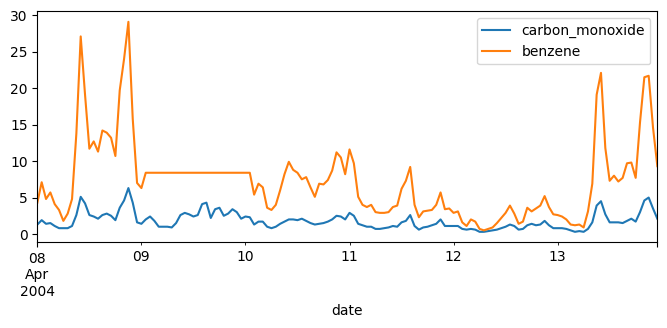

In [67]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .bfill()
 .plot(figsize=(8,3))
)

In [68]:
(
    air_df_pl.with_columns(
        date=pl.col("date")
        .dt.replace_time_zone("UTC")
        .dt.convert_time_zone("Europe/Rome")
    )
    .select(["date", "carbon_monoxide", "benzene"])
    .filter(
        pl.col("date").is_between(
            datetime(2004, 4, 8, tzinfo=pytz.timezone("Europe/Rome")),
            datetime(2004, 4, 14, tzinfo=pytz.timezone("Europe/Rome")),
        )
    )
    .with_columns(
        pl.col(pl.Float64)
        .replace({-200: None})
        .backward_fill()  # backward fill works with pl.Expr
    )
    .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

<Axes: xlabel='date'>

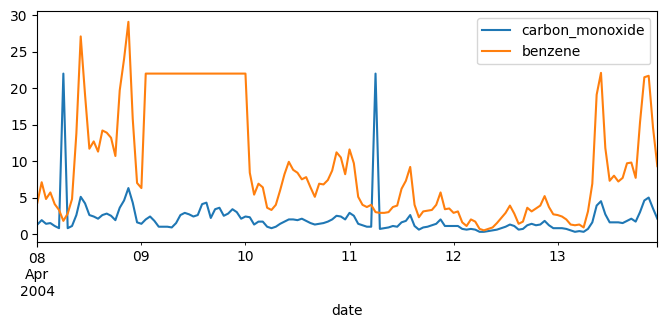

In [69]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .fillna(22)
 .plot(figsize=(8,3))
)

<Axes: xlabel='date'>

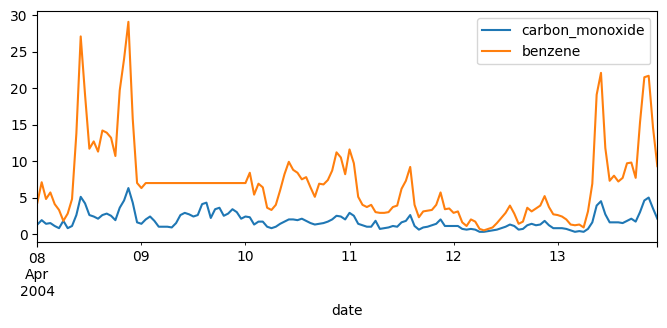

In [70]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .pipe(lambda df_: df_.fillna(df_.mean()))
 .plot(figsize=(8,3))
)

In [72]:
(
    air_df_pl.with_columns(
        date=pl.col("date")
        .dt.replace_time_zone("UTC")
        .dt.convert_time_zone("Europe/Rome")
    )
    .select(["date", "carbon_monoxide", "benzene"])
    .filter(
        pl.col("date").is_between(
            datetime(2004, 4, 8, tzinfo=pytz.timezone("Europe/Rome")),
            datetime(2004, 4, 14, tzinfo=pytz.timezone("Europe/Rome")),
        )
    )
    .with_columns(
        pl.col(pl.Float64)
        .replace({-200: None})
    )
    .fill_null(strategy="mean")
    .plot(x="date", y=["carbon_monoxide", "benzene"])
)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

## Resampling

In [84]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 #.plot(figsize=(8,3))
)

,carbon_monoxide,benzene
date,,
2004-04-08 00:00:00+02:00,1.3,4.3
2004-04-08 01:00:00+02:00,1.9,7.1
2004-04-08 02:00:00+02:00,1.4,4.8
2004-04-08 03:00:00+02:00,1.5,5.7
2004-04-08 04:00:00+02:00,1.1,4.1
...,...,...
2004-04-13 19:00:00+02:00,3.0,15.3
2004-04-13 20:00:00+02:00,4.6,21.5
2004-04-13 21:00:00+02:00,5.0,21.7


<Axes: xlabel='date'>

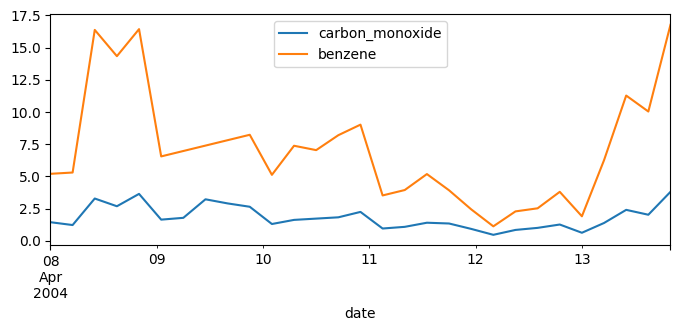

In [85]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 .resample('5h')
 .mean()
 .plot(figsize=(8,3))
)

In [86]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 .resample('2h37min')
 .mean()
)

,carbon_monoxide,benzene
date,,
2004-04-08 00:00:00+02:00,1.533333,5.400000
2004-04-08 02:37:00+02:00,1.133333,4.366667
2004-04-08 05:14:00+02:00,0.800000,2.300000
2004-04-08 07:51:00+02:00,2.933333,15.233333
2004-04-08 10:28:00+02:00,3.066667,14.500000
2004-04-08 13:05:00+02:00,2.350000,12.750000
2004-04-08 15:42:00+02:00,2.400000,12.600000
2004-04-08 18:19:00+02:00,4.100000,21.850000
2004-04-08 20:56:00+02:00,4.066667,17.300000


<Axes: xlabel='date'>

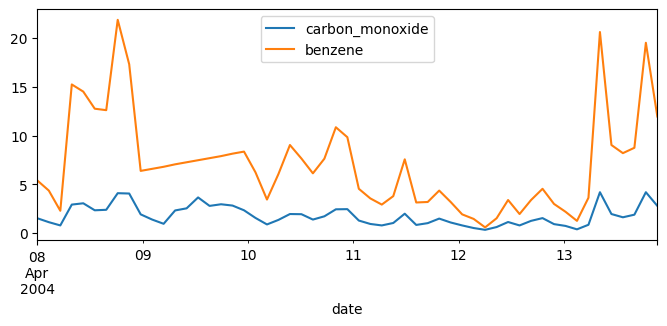

In [87]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/04/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 .resample('2h37min')
 .mean()
 .plot(figsize=(8,3)) 
)

<Axes: xlabel='date'>

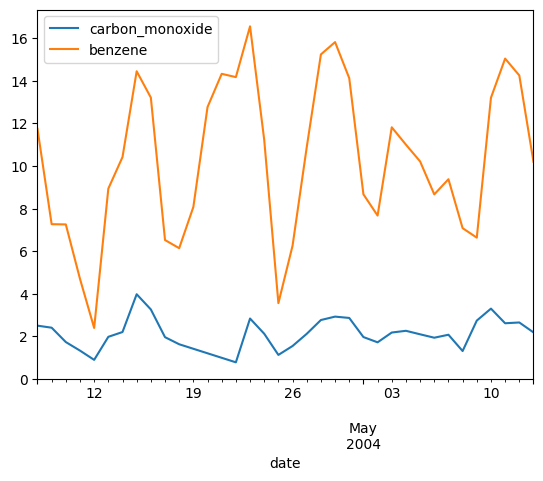

In [88]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2004/05/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 .resample('1d')
 .mean()
 .plot()
)

<Axes: xlabel='date'>

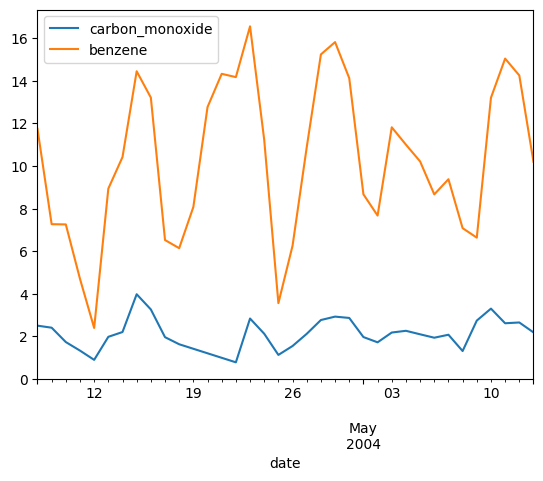

In [89]:
# Note: You can also use pd.Grouper and .groupby
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 #.set_index('date')
 #.loc['2004/04/08':'2004/05/13', ['carbon_monoxide', 'benzene']] 
 .loc[:, ['date', 'carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
# .astype(float)
 .astype({'carbon_monoxide': float, 'benzene': float})
 .interpolate()
# #.resample('1d')
 .groupby(pd.Grouper(key='date', freq='1d'))
 .mean()
 .loc['2004/04/08':'2004/05/13']
 .plot()
)

## Rolling

<Axes: xlabel='date'>

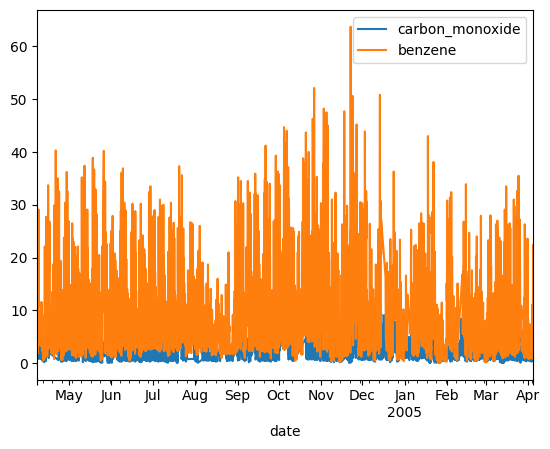

In [79]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2005/05/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()  #.interpolate works with Pandas 1.x
 .plot()
)

<Axes: xlabel='date'>

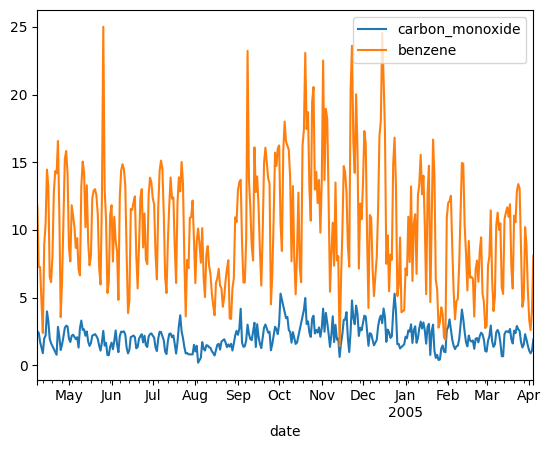

In [80]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2005/05/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 .resample('d')
 .mean()
 .interpolate()
 .plot()
)

<Axes: xlabel='date'>

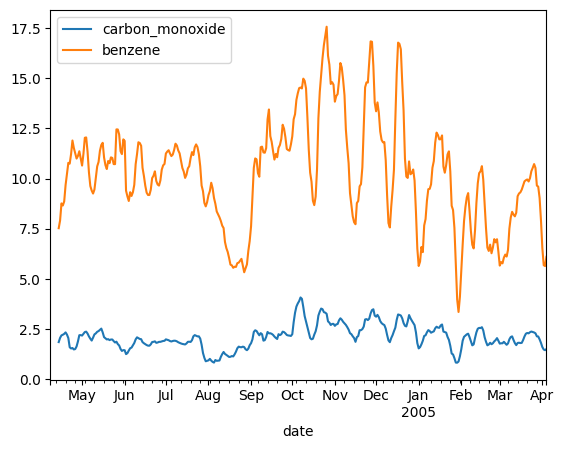

In [81]:
(air_df
 .assign(date=air_df.date.dt.tz_localize(tz='UTC').dt.tz_convert('Europe/Rome'))
 .set_index('date')
 .loc['2004/04/08':'2005/05/13', ['carbon_monoxide', 'benzene']] 
 .replace(-200, np.nan)
 .astype(float)
 .interpolate()
 .resample('d')
 .mean()
 .interpolate()
 .rolling(7)
 .mean()
 .plot()
)

## Fix the Function

In [82]:
# fix the -200 values
def tweak_air_qual(df: pd.DataFrame) -> pd.DataFrame:
  return (df
   .loc[df.isna().sum(axis='columns') < 17]
   .assign(date=lambda df_: pd.to_datetime(df_.Date + ' ' + \
                      df_.Time.replace(r'\.', ':', regex=True),
                                          dayfirst=True))
   .rename(columns={'CO(GT)': 'carbon_monoxide',
                    'PT08.S1(CO)': 'tin_oxide',
                    'NMHC(GT)': 'non_metallic_hydro_carb',
                    'C6H6(GT)': 'benzene',
                    'PT08.S2(NMHC)': 'titania',
                    'NOx(GT)': 'nox',
                    'PT08.S3(NOx)': 'tungsten_oxide_nox',
                    'NO2(GT)': 'no2',
                    'PT08.S4(NO2)':  'tungsten_oxide_no2',
                    'PT08.S5(O3)': 'indium_oxide',
                    'T': 'temp',
                    'RH': 'rel_humid',
                    'AH': 'abs_humid'})
   .loc[:, ['carbon_monoxide', 'tin_oxide',
         'non_metallic_hydro_carb', 'benzene', 'titania', 'nox',
         'tungsten_oxide_nox', 'no2', 'tungsten_oxide_no2', 'indium_oxide',
         'temp', 'rel_humid', 'abs_humid', 'date']]
   .pipe(lambda df_: df_.assign(**{col: df_[col].str.replace(',','.').astype(float)
                                  for col in
        ['carbon_monoxide', 'benzene', 'temp', 'rel_humid', 'abs_humid']}))
   .replace(-200, np.nan)
  )

with zipfile.ZipFile('data/AirQualityUCI.zip') as zip:
  df = pd.read_csv(zip.open('AirQualityUCI.csv'), sep=';',
                  dtype_backend='pyarrow', #engine='pyarrow',
                  )

air_df = tweak_air_qual(df)  

In [83]:
air_df

,carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314,<NA>,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,2005-04-04 10:00:00
9353,2.4,1163,<NA>,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,2005-04-04 11:00:00
9354,2.4,1142,<NA>,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,2005-04-04 12:00:00
9355,2.1,1003,<NA>,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,2005-04-04 13:00:00


In [90]:
def tweak_air_qual_pl(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.filter(~pl.all_horizontal(pl.all().is_null()))
        .with_columns(
            date=pl.col("Date") + " " + pl.col("Time").str.replace_all(r"\.", ":")
        )
        .with_columns(date=pl.col("date").str.to_datetime())
        .rename(
            {
                "CO(GT)": "carbon_monoxide",
                "PT08.S1(CO)": "tin_oxide",
                "NMHC(GT)": "non_metallic_hydro_carb",
                "C6H6(GT)": "benzene",
                "PT08.S2(NMHC)": "titania",
                "NOx(GT)": "nox",
                "PT08.S3(NOx)": "tungsten_oxide_nox",
                "NO2(GT)": "no2",
                "PT08.S4(NO2)": "tungsten_oxide_no2",
                "PT08.S5(O3)": "indium_oxide",
                "T": "temp",
                "RH": "rel_humid",
                "AH": "abs_humid",
            }
        )
        .select(
            [
                "carbon_monoxide",
                "tin_oxide",
                "non_metallic_hydro_carb",
                "benzene",
                "titania",
                "nox",
                "tungsten_oxide_nox",
                "no2",
                "tungsten_oxide_no2",
                "indium_oxide",
                "temp",
                "rel_humid",
                "abs_humid",
                "date",
            ]
        )
        .with_columns(
            **{
                col: pl.col(col).str.replace(r"\,", ".").cast(pl.Float64)
                for col in [
                    "carbon_monoxide",
                    "benzene",
                    "temp",
                    "rel_humid",
                    "abs_humid",
                ]
            }
        )
        .with_columns(pl.col(pl.Float64).replace({-200: None}))
    )

In [92]:
air_df_pl = tweak_air_qual_pl(df_pl)

In [93]:
air_df_pl

carbon_monoxide,tin_oxide,non_metallic_hydro_carb,benzene,titania,nox,tungsten_oxide_nox,no2,tungsten_oxide_no2,indium_oxide,temp,rel_humid,abs_humid,date
f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,datetime[μs]
2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00
1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,2004-03-10 23:00:00
1.2,1185,31,3.6,690,62,1462,77,1333,733,11.3,56.8,0.7603,2004-03-11 00:00:00
1.0,1136,31,3.3,672,62,1453,76,1333,730,10.7,60.0,0.7702,2004-03-11 01:00:00
0.9,1094,24,2.3,609,45,1579,60,1276,620,10.7,59.7,0.7648,2004-03-11 02:00:00
